# Классификация токсичных твитов

Решаемая задача

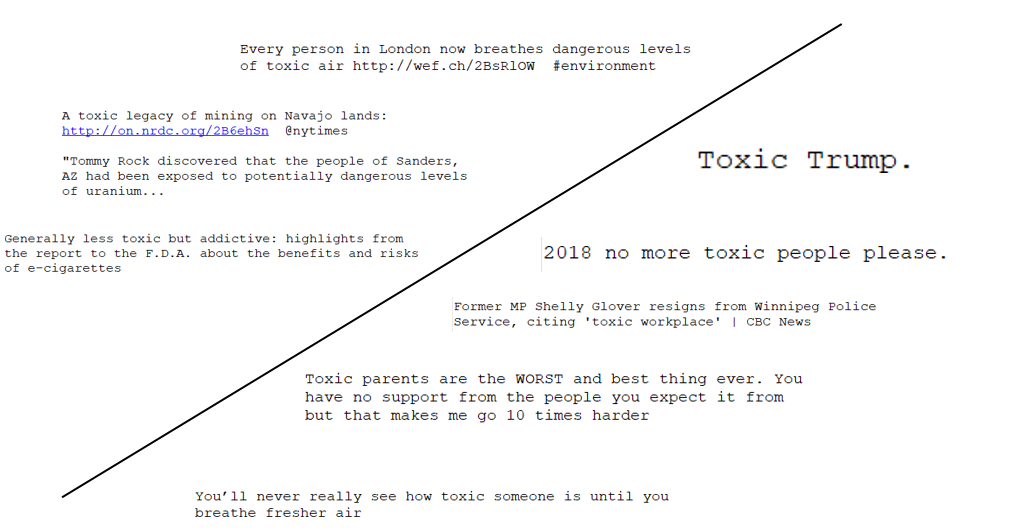

Общая схема работы

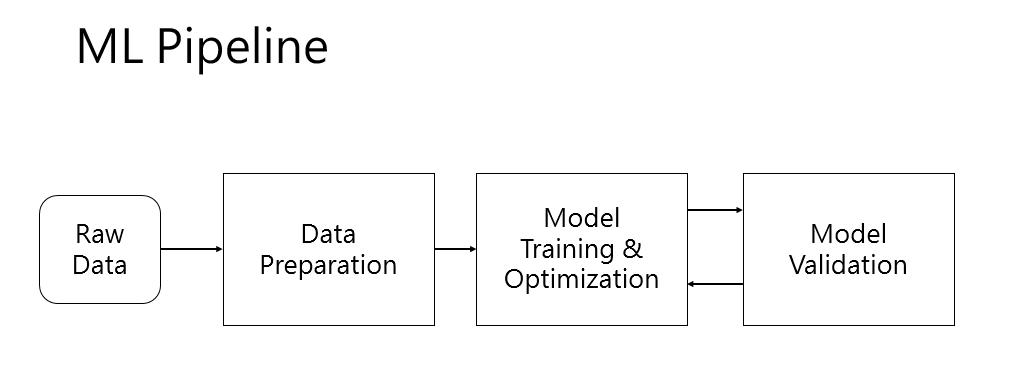

Используемые инструменты

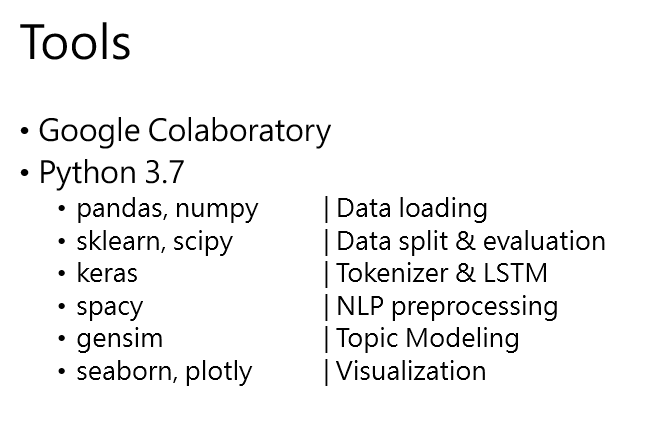

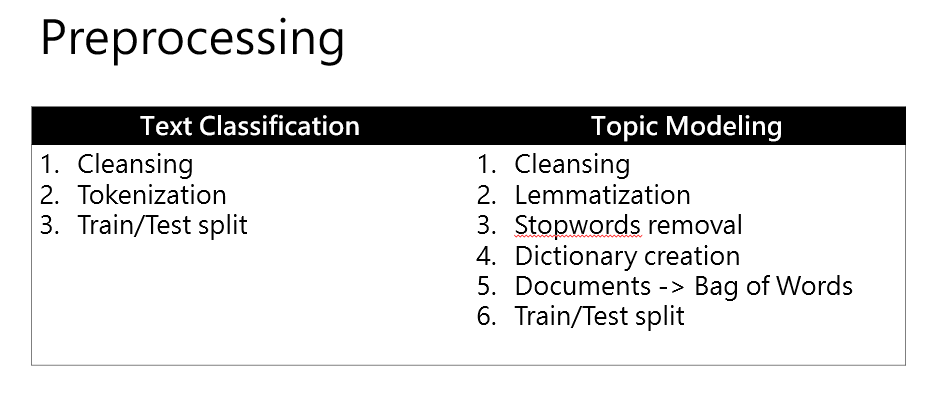

**Если есть необходимость, можно запустить весь код самостоятельно.**

Данные можно скачать по [ссылке](https://drive.google.com/drive/folders/1Zi-FD7oqHxtVjGMmEOW88UdlGayAKxED?usp=sharing).

После этого помещаете их в любую папку на своём google drive, и ниже в переменной path указываете путь до этой ПАПКИ.

In [1]:
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
from sklearn.utils import shuffle
from scipy.signal import resample
import matplotlib.pyplot as plt

np.random.seed(42)


# Load the Drive helper and mount
from google.colab import drive
import os
# This will prompt for authorization.
drive.mount('/content/drive',force_remount=True)
# drive/My Drive/путь/к/файлу
path = 'drive/My Drive/toxic_data/'

# Any results you write to the current directory are saved as output.

ModuleNotFoundError: No module named 'google.colab'

Категории твитов:

* 1 - STEM (Сюда попали твиты, где toxic\#toxic употребляются в значении биологической\химической токсичности)
* 2 - Social (Твиты, где toxic\#toxic использовано в отношении человека, действия или поведения (исключены случаи, когда в твитах первостепенная STEM))
* 4 – Britney cluster (мы выделили его отдельный поскольку предполагаем, что именно песня (как это ни странно звучит) стала в некотором роде событием, когда токсичность в социальном контексте стала укоренена в массовой культуре) Возможно с этим кластером стоит произвести дополнительную работу, перераспределив его по другим, а “4” использовать как  дополнительный параметр.
* 0 – Unknown (твиты на языках кроме английского или записи не несущие смысла, которые человеку трудно отнести в ту или иную категорию)

Идея проекта: на основании размеченных твитов построить модель, способную распределить все остальные твиты по имеющимся категориям.

### Загрузка данных

Считываем данные из экселевских файлов, избавляемся от бесполезных признаков

In [0]:
df = pd.read_excel(path+"toxic_2018_label_tag.xlsx")
df2 = pd.read_excel(path+"toxic_2018_label.xlsx")
df = df.drop(columns=['Collected','Unnamed: 6'])
df2 = df2.drop(columns=['Collected'])

Очищаем данные от неразмеченных образцов

In [4]:
df = df.dropna()
df2 = df2.dropna()
df['Label'] = df['Label'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6412 entries, 0 to 7178
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     6412 non-null   object
 1   Account  6412 non-null   object
 2   Date     6412 non-null   object
 3   Message  6412 non-null   object
 4   Label    6412 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 300.6+ KB


Объединяем данные

In [0]:
df = df.append(df2)
df = df[(df['Label'] == 0)|(df['Label'] == 1)|(df['Label'] == 2)|(df['Label'] == 4)]

Итого получаем 43119 размеченных записей

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43119 entries, 0 to 37088
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     43119 non-null  object
 1   Account  43119 non-null  object
 2   Date     43119 non-null  object
 3   Message  43119 non-null  object
 4   Label    43119 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


Количество представителей каждой категории:

In [7]:
df['Label'].value_counts()

2    30718
1     7525
0     4336
4      540
Name: Label, dtype: int64

In [8]:
df['Message'][1]

1    Dear singing celebrities, if you are going to ...
1    Alright babes who is going to up their game in...
Name: Message, dtype: object

In [10]:
df.head()

,Name,Account,Date,Message,Label
0,Bill Ward,@Billward10Bill,1 янв. 2018 г.,#toxic minds discover gavin shawlens thrillers...,0
1,Ryan Gage,@singerunlimited,1 янв. 2018 г.,"dear singing celebrities, if you are going to ...",2
2,Martin G. Reynolds,@reynoldspost,1 янв. 2018 г.,the world is better when @britneyspears is put...,4
3,sydney ryan,@sydddryan,1 янв. 2018 г.,the fact that i started off 2018 by watching a...,4
4,Siara,@CrouchinBunny,1 янв. 2018 г.,watching @britneyspears live on new year’s eve...,4


### Препроцессинг

Очищаем сообщения от технических символов

In [0]:
def clean_message(msg: str):
  return msg.replace("\n", " ").lower()

df['Message'] = df['Message'].apply(clean_message)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

Токенизируем содержание твитов. Для обучение и тестирования сети используем ТОЛЬКО содержание твитов и меток.

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 73181 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (43119, 200)


In [14]:
Y = pd.get_dummies(df['Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (43119, 4)


Разбиваем данные на тренировочный и тестовый сеты

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(38807, 200) (38807, 4)
(4312, 200) (4312, 4)


### Создание и обучение модели

Используемая архитектура - Long-Short Term Memory (LSTM), развитие идеи RNN.

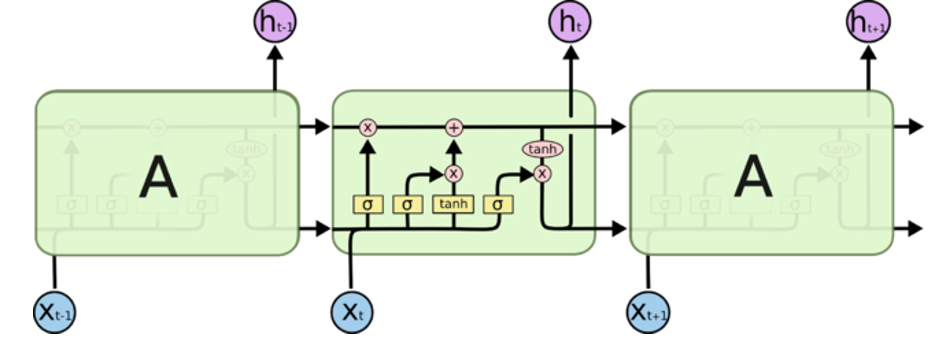

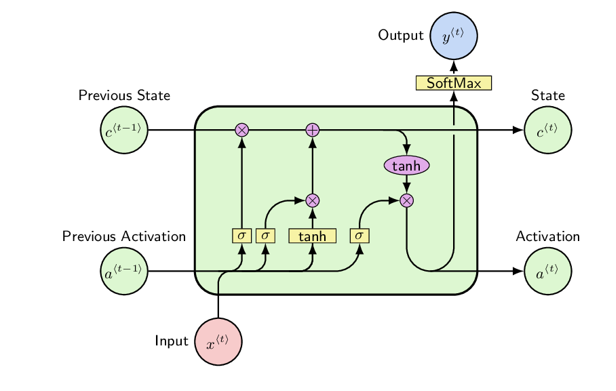

In [0]:
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

Создаём модель с архитектурой LSTM

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                4440      
_________________________________________________________________
dense (Dense)                (None, 4)                 44        
Total params: 5,004,484
Trainable params: 5,004,484
Non-trainable params: 0
_________________________________________________________________


Обучаем модель

In [39]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
546/546 [==============================] - 33s 61ms/step - loss: 0.6116 - accuracy: 0.7976 - val_loss: 0.4491 - val_accuracy: 0.8557
Epoch 2/5
546/546 [==============================] - 33s 61ms/step - loss: 0.3355 - accuracy: 0.8919 - val_loss: 0.4266 - val_accuracy: 0.8637
Epoch 3/5
546/546 [==============================] - 33s 60ms/step - loss: 0.2213 - accuracy: 0.9315 - val_loss: 0.4886 - val_accuracy: 0.8464
Epoch 4/5
546/546 [==============================] - 33s 60ms/step - loss: 0.1476 - accuracy: 0.9560 - val_loss: 0.5208 - val_accuracy: 0.8441
Epoch 5/5
546/546 [==============================] - 33s 60ms/step - loss: 0.1020 - accuracy: 0.9706 - val_loss: 0.5953 - val_accuracy: 0.8454


In [0]:
model.save(path+'myLSTM')

### Оценка качества модели

In [41]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

135/135 [==============================] - 1s 6ms/step - loss: 0.5619 - accuracy: 0.8483
Test set
  Loss: 0.562
  Accuracy: 0.848


Изменение loss'a за время обучения модели. После первой эпохи модель переобучивается.

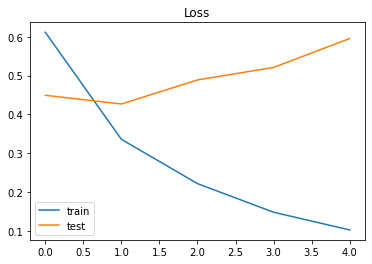

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Оцениваем точность

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
Y_pred = model.predict(X_test)

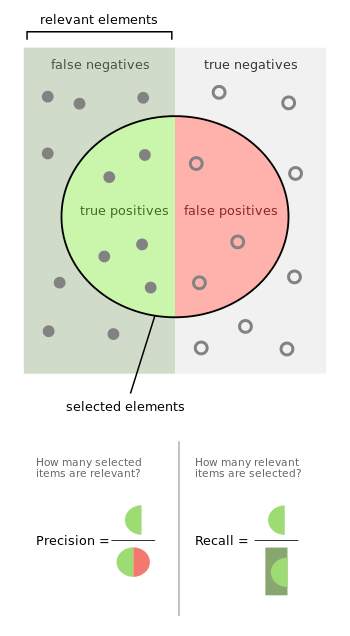

In [45]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.35      0.43       465
           1       0.82      0.78      0.80       728
           2       0.88      0.94      0.91      3072
           3       0.95      0.83      0.89        47

    accuracy                           0.85      4312
   macro avg       0.80      0.73      0.76      4312
weighted avg       0.84      0.85      0.84      4312



In [0]:
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Матрица ошибок

Confusion matrix, without normalization


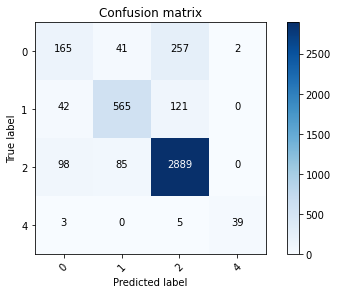

In [48]:
plot_confusion_matrix(cm, ['0','1','2','4'])

### Выводы

В результате анализа данных и обучения сети были получены следующие результаты и выводы:
1. Данные не сбалансированы. Подавляющее большинство твитов относятся к категории социальной токсичности, из-за чего сеть становится предвзятой и классифицирует социальную токсичность там, где её нет. Расширение и улучшение датасета улучшит качество модели. Этого можно достичь, добавив в него больше объектов не 2й категории, а также добавляя объекты всех категорий без содержания слова/хештега toxic.
2. Получен начальный baseline точности 0.84. Эти показатели можно улучшить множеством способов (fine-tuning, использование pretrained language models, использование других признаков из датасета, помимо сообщения)

# Тематическое моделирование при помощи LDA


1. Идея там такая. Нужно потом взять категорию два и по ней построить тематическую модель, т.е. выделить темы, к которым относятся эти твиты. Например, алгоритмом LDA (latent Dirichle allocation).
Дальше хочется на временной оси отметить активность каждой выделенной темы (в штуках твитов за день/неделю/месяц).
Затем ретроспективно связать пики активности с какими-то событиями, произошедшими в мире.

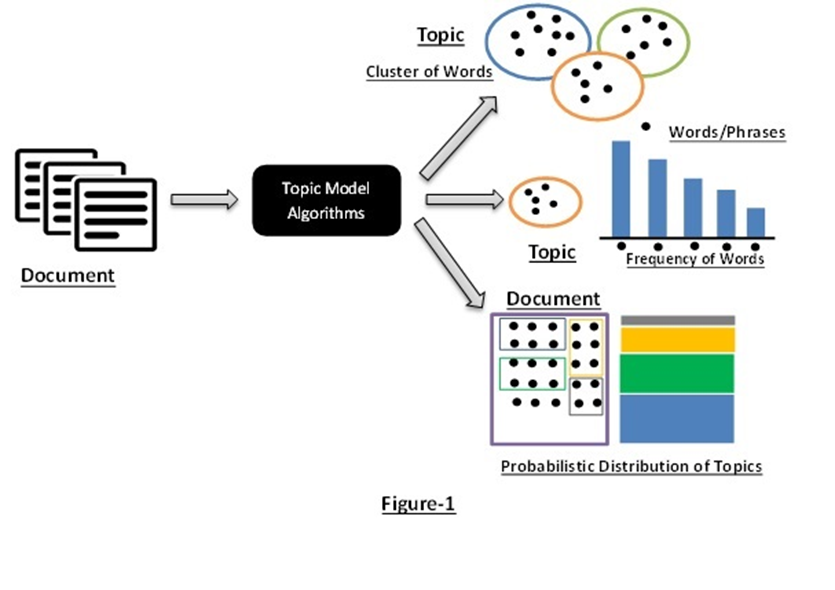

Трансформеры для лучшей классификации
https://explosion.ai/blog/spacy-transformers

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619

### Imports

In [49]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.callbacks import PerplexityMetric, CallbackAny2Vec

# spacy for lemmatization
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

# Pretty print and loading bars
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Extracting text data 

In [0]:
# From df
df_toxic = df[df['Label']==2]

In [0]:
# Or from file
df_toxic = pd.read_csv(path+'df_toxic_dump.csv')

### Creating pipeline

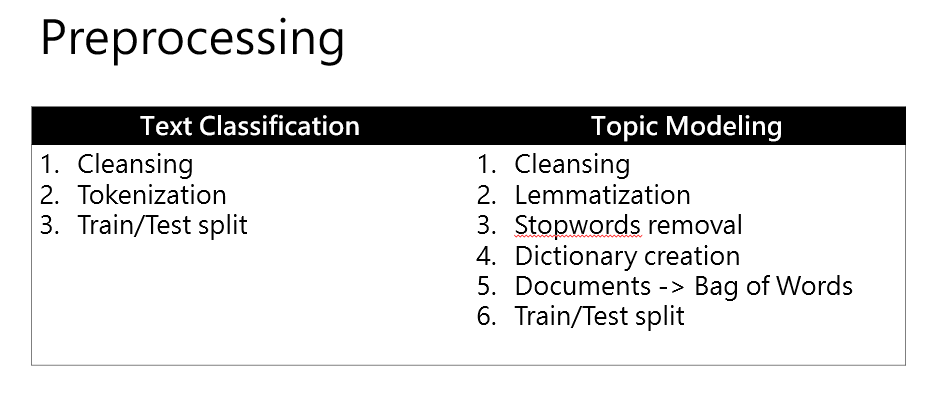

In [0]:
nlp = spacy.load("en_core_web_sm")

In [0]:
nlp.Defaults.stop_words.update(['toxic', 'Toxic','█', 
                                '\n','\n ','\n  ', '\n   ' '\n\n', "\n\n ", 
                                "  ", "|", '$',
                                'u', 'ur', 'people'
                                ])
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [0]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

### Loading data into pipeline

In [56]:
# Faster
doc_list = []
# Iterates through batches of articles article in the corpus.
for doc in tqdm(nlp.pipe(df_toxic.Message),desc='tqdm'):
    doc_list.append(doc)

In [57]:
# Compare original
df_toxic.Message.values[3]

'be #thankful for the #difficult #people in your #life, for they have shown you who you do not want to be. #wisdom #wednesdaywisdom #gratitude #drama #negative #nonegativity #nodrama #toxic '

In [58]:
# And preprocessed string
doc_list[3]

['thankful',
 'difficult',
 'life',
 'want',
 'wisdom',
 'wednesdaywisdom',
 'gratitude',
 'drama',
 'negative',
 'nonegativity',
 'nodrama']

### Creating model inputs

In [0]:
# Creates DICTIONARY which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

### Creating gensim LDA model

Train single-core LDA model

In [0]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

LDA multicore trains faster

In [0]:
%%time
lda_multi_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=words,
                                           workers=3,
                                           num_topics=20, 
                                           random_state=2,
                                           passes=10,
                                           per_word_topics=True)

CPU times: user 1min 12s, sys: 4.24 s, total: 1min 16s
Wall time: 2min 24s


In [0]:
# Print the Keyword in all topics
pprint(lda_multi_model.print_topics())
doc_lda = lda_multi_model[corpus]

[(0,
  '0.042*"fandom" + 0.018*"fan" + 0.017*"stan" + 0.017*"like" + 0.014*"hate" + '
  '0.011*"know" + 0.008*"group" + 0.007*"army" + 0.007*"armys" + 0.007*"want"'),
 (1,
  '0.007*"leader" + 0.006*"Tory" + 0.006*"community" + 0.006*"Labour" + '
  '0.005*"good" + 0.004*"Corbyn" + 0.004*"racist" + 0.004*"UK" + '
  '0.004*"address" + 0.003*"Party"'),
 (2,
  '0.020*"parent" + 0.015*"child" + 0.007*"stress" + 0.006*"family" + '
  '0.006*"powerful" + 0.005*"reaction" + 0.005*"report" + 0.005*"mother" + '
  '0.005*"kid" + 0.005*"far"'),
 (3,
  '0.008*"anti" + 0.007*"drive" + 0.007*"Trump" + 0.007*"let" + 0.007*"use" + '
  '0.006*"political" + 0.005*"public" + 0.005*"lie" + 0.005*"right" + '
  '0.005*"high"'),
 (4,
  '0.052*"life" + 0.023*"love" + 0.021*"person" + 0.021*"good" + '
  '0.019*"relationship" + 0.017*"let" + 0.015*"cut" + 0.014*"thing" + '
  '0.013*"feel" + 0.013*"time"'),
 (5,
  '0.008*"victim" + 0.006*"play" + 0.005*"culture" + 0.005*"Star" + '
  '0.005*"correct" + 0.005*"cry" +

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_multi_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multi_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.884684928139492

Coherence Score:  0.34830637796266534


## Finding optimal n of topics for LDA

In [0]:
def compute_gen_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=words,
                                           workers=3,
                                           num_topics=num_topics, 
                                           random_state=2,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
limit=30; start=8; step=3;
# Can take a long time to run.
gen_model_list, gen_coherence_values = compute_gen_coherence_values(
                                                                    dictionary=words, 
                                                                    corpus=corpus, 
                                                                    texts=doc_list, 
                                                                    start=start, 
                                                                    limit=limit, 
                                                                    step=step
    )

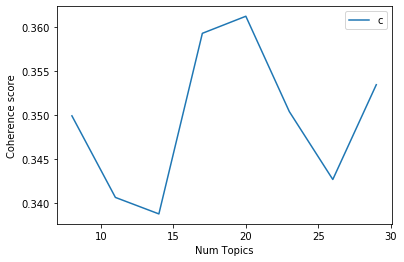

In [0]:
# Show graph
x = range(start, limit, step)
plt.plot(x, gen_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
for m, cv in zip(x, gen_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 8  has Coherence Value of 0.3499
Num Topics = 11  has Coherence Value of 0.3406
Num Topics = 14  has Coherence Value of 0.3388
Num Topics = 17  has Coherence Value of 0.3593
Num Topics = 20  has Coherence Value of 0.3612
Num Topics = 23  has Coherence Value of 0.3504
Num Topics = 26  has Coherence Value of 0.3427
Num Topics = 29  has Coherence Value of 0.3535


### Choosing optimal model

In [0]:
# Select the model and print the topics
model_name = "" # CHANAGE THIS EVERY TIME
optimal_model = lda_multi_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.042*"fandom" + 0.018*"fan" + 0.017*"stan" + 0.017*"like" + 0.014*"hate" + '
  '0.011*"know" + 0.008*"group" + 0.007*"army" + 0.007*"armys" + 0.007*"want" '
  '+ 0.007*"bts" + 0.007*"stop" + 0.007*"think" + 0.006*"twitter" + '
  '0.006*"BTS"'),
 (1,
  '0.007*"leader" + 0.006*"Tory" + 0.006*"community" + 0.006*"Labour" + '
  '0.005*"good" + 0.004*"Corbyn" + 0.004*"racist" + 0.004*"UK" + '
  '0.004*"address" + 0.003*"Party" + 0.003*"Tories" + 0.003*"tonight" + '
  '0.003*"politic" + 0.003*"church" + 0.003*"hope"'),
 (2,
  '0.020*"parent" + 0.015*"child" + 0.007*"stress" + 0.006*"family" + '
  '0.006*"powerful" + 0.005*"reaction" + 0.005*"report" + 0.005*"mother" + '
  '0.005*"kid" + 0.005*"far" + 0.005*"system" + 0.004*"tolerate" + '
  '0.004*"effect" + 0.004*"childhood" + 0.004*"red"'),
 (3,
  '0.008*"anti" + 0.007*"drive" + 0.007*"Trump" + 0.007*"let" + 0.007*"use" + '
  '0.006*"political" + 0.005*"public" + 0.005*"lie" + 0.005*"right" + '
  '0.005*"high" + 0.005*"job" + 0.004

In [0]:
optimal_model.save(path+"lda_model_20t_361score")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Covert MALLET to Gensim

In [0]:
optimal_gen_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [0]:
coherencemodel = CoherenceModel(model=optimal_gen_model, texts=doc_list, dictionary=words, coherence='c_v')
print (coherencemodel.get_coherence())

0.8078385304294353


In [0]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.019*"Trump" + 0.017*"point" + 0.015*"word" + 0.012*"live" + '
  '0.012*"school" + 0.010*"high" + 0.010*"power" + 0.009*"free" + 0.008*"home" '
  '+ 0.007*"question" + 0.007*"death" + 0.006*"body" + 0.006*"include" + '
  '0.006*"level" + 0.006*"trump"'),
 (1,
  '0.011*"politic" + 0.010*"political" + 0.010*"country" + 0.009*"attack" + '
  '0.009*"party" + 0.008*"vote" + 0.008*"racist" + 0.007*"anti" + '
  '0.007*"state" + 0.006*"system" + 0.006*"public" + 0.006*"view" + '
  '0.005*"win" + 0.005*"join" + 0.005*"platform"'),
 (2,
  '0.120*"relationship" + 0.080*"love" + 0.039*"leave" + 0.029*"feel" + '
  '0.021*"find" + 0.020*"grow" + 0.020*"deserve" + 0.020*"realize" + '
  '0.020*"girl" + 0.018*"person" + 0.017*"end" + 0.017*"friendship" + '
  '0.015*"treat" + 0.015*"abusive" + 0.013*"hard"'),
 (3,
  '0.065*"good" + 0.047*"friend" + 0.043*"bad" + 0.036*"talk" + 0.035*"shit" + '
  '0.026*"start" + 0.024*"fuck" + 0.020*"real" + 0.016*"People" + 0.015*"ur" + '
  '0.014*"ass" + 0.01

### Finding the dominant topic in each sentence

In [0]:
a = optimal_model[corpus[0]]

In [0]:
a

In [0]:
topics_words = pd.DataFrame(optimal_model.show_topics(), columns=['Topic','Words'])

In [0]:
topics_words.to_csv(path+"topic_df_dump.csv")

In [0]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']
    return(sent_topics_df)


df_topics = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=doc_list)

# Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_topics.head(10)

,Dominant_Topic,Perc_Contribution
0,18.0,0.5364
1,0.0,0.8812
2,12.0,0.5933
3,4.0,0.3174
4,13.0,0.3568
5,18.0,0.7635
6,1.0,0.8905
7,11.0,0.4276
8,16.0,0.5371
9,14.0,0.7098


In [0]:
df_topics.to_csv(path+"df_topics_dump2.csv")

In [0]:
df_toxic.to_csv(path+"df_toxic_dump.csv")

### Find the most representative document for each topic

In [0]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

### Topic distribution across documents

In [0]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

## View topic distribution over the year

In [0]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(16, 10)})

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [0]:
# Loading data
df_toxic = pd.read_csv(path+'df_toxic_dump.csv')
df_topics = pd.read_csv(path+'df_topics_dump2.csv', index_col=0)

In [0]:
# Copying dates
df_topics['Date'] = df_toxic["Date"].values

In [70]:
months = {
    'янв.': u'01',
    'февр.': u'02',
    'мар.': u'03',
    'апр.': u'04',
    'мая': u'05',
    'июн.': u'06',
    'июл.': u'07',
    'авг.': u'08',
    'сент.': u'09',
    'окт.': u'10',
    'нояб.': u'11',
    'дек.': u'12'
}

def to_date(string):
  if type(string) != str or len(string)<2:
    return np.datetime64('2017-12-31')
  date = string.split()
  day = date[0]
  month = months[date[1]]
  year = date[2]
  return np.datetime64('{0}-{1}-{2}'.format(year,month, day.zfill(2) ).encode('utf-8'))

to_date('4 окт. 2018 г.')

numpy.datetime64('2018-10-04')

In [0]:
df_topics['Date'] = df_topics['Date'].apply(to_date)
df_topics['Topic'] = df_topics['Dominant_Topic'].apply(lambda x: int(x))
df_topics = df_topics.drop('Dominant_Topic', axis=1)
df_topics = df_topics.drop('Perc_Contribution', axis=1)

Количество твитов каждого топика

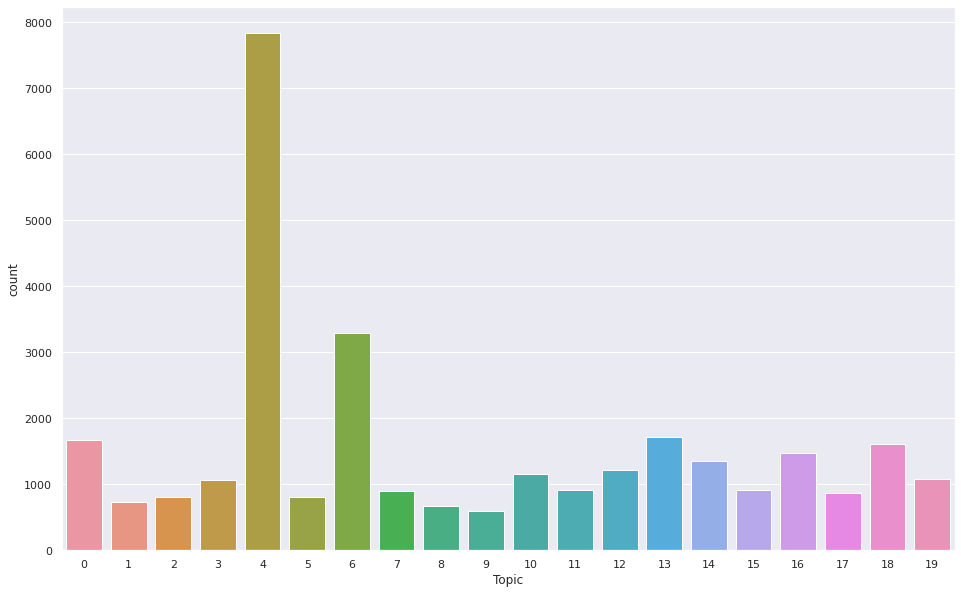

In [72]:
sns.countplot(x='Topic', data=df_topics)

Отображение распределения одного топика по временной шкале

In [73]:
# Plot for one topic
topic = 1 # Change to desired topic
df_cat1 = df_topics[df_topics['Topic']==topic].groupby('Date').count()
fig = go.Figure(data=[go.Scatter(x=df_cat1.index, y=df_cat1['Topic'])])
fig.show()

Отображение всех топиков по временной шкале. График интерактивный. Можно выделить желаемый период и выбрать только интересующие топики из списка справа. Двойное нажатие на топик выделяет только его.

In [74]:
# Plot all data
N = 20 # Number of topics
fig = go.Figure()
for i in range(N):
  df = df_cat1 = df_topics[df_topics['Topic']==i].groupby('Date').count()
  fig.add_trace(go.Scatter(x=df.index, y=df['Topic'], name=f"Topic {i}"))

fig.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()

Подробное содержание каждого топика

[(0,
  '0.042*"fandom" + 0.018*"fan" + 0.017*"stan" + 0.017*"like" + 0.014*"hate" + '
  '0.011*"know" + 0.008*"group" + 0.007*"army" + 0.007*"armys" + 0.007*"want"'),
 (1,
  '0.007*"leader" + 0.006*"Tory" + 0.006*"community" + 0.006*"Labour" + '
  '0.005*"good" + 0.004*"Corbyn" + 0.004*"racist" + 0.004*"UK" + '
  '0.004*"address" + 0.003*"Party"'),
 (2,
  '0.020*"parent" + 0.015*"child" + 0.007*"stress" + 0.006*"family" + '
  '0.006*"powerful" + 0.005*"reaction" + 0.005*"report" + 0.005*"mother" + '
  '0.005*"kid" + 0.005*"far"'),
 (3,
  '0.008*"anti" + 0.007*"drive" + 0.007*"Trump" + 0.007*"let" + 0.007*"use" + '
  '0.006*"political" + 0.005*"public" + 0.005*"lie" + 0.005*"right" + '
  '0.005*"high"'),
 (4,
  '0.052*"life" + 0.023*"love" + 0.021*"person" + 0.021*"good" + '
  '0.019*"relationship" + 0.017*"let" + 0.015*"cut" + 0.014*"thing" + '
  '0.013*"feel" + 0.013*"time"'),
 (5,
  '0.008*"victim" + 0.006*"play" + 0.005*"culture" + 0.005*"Star" + '
  '0.005*"correct" + 0.005*"cry" +